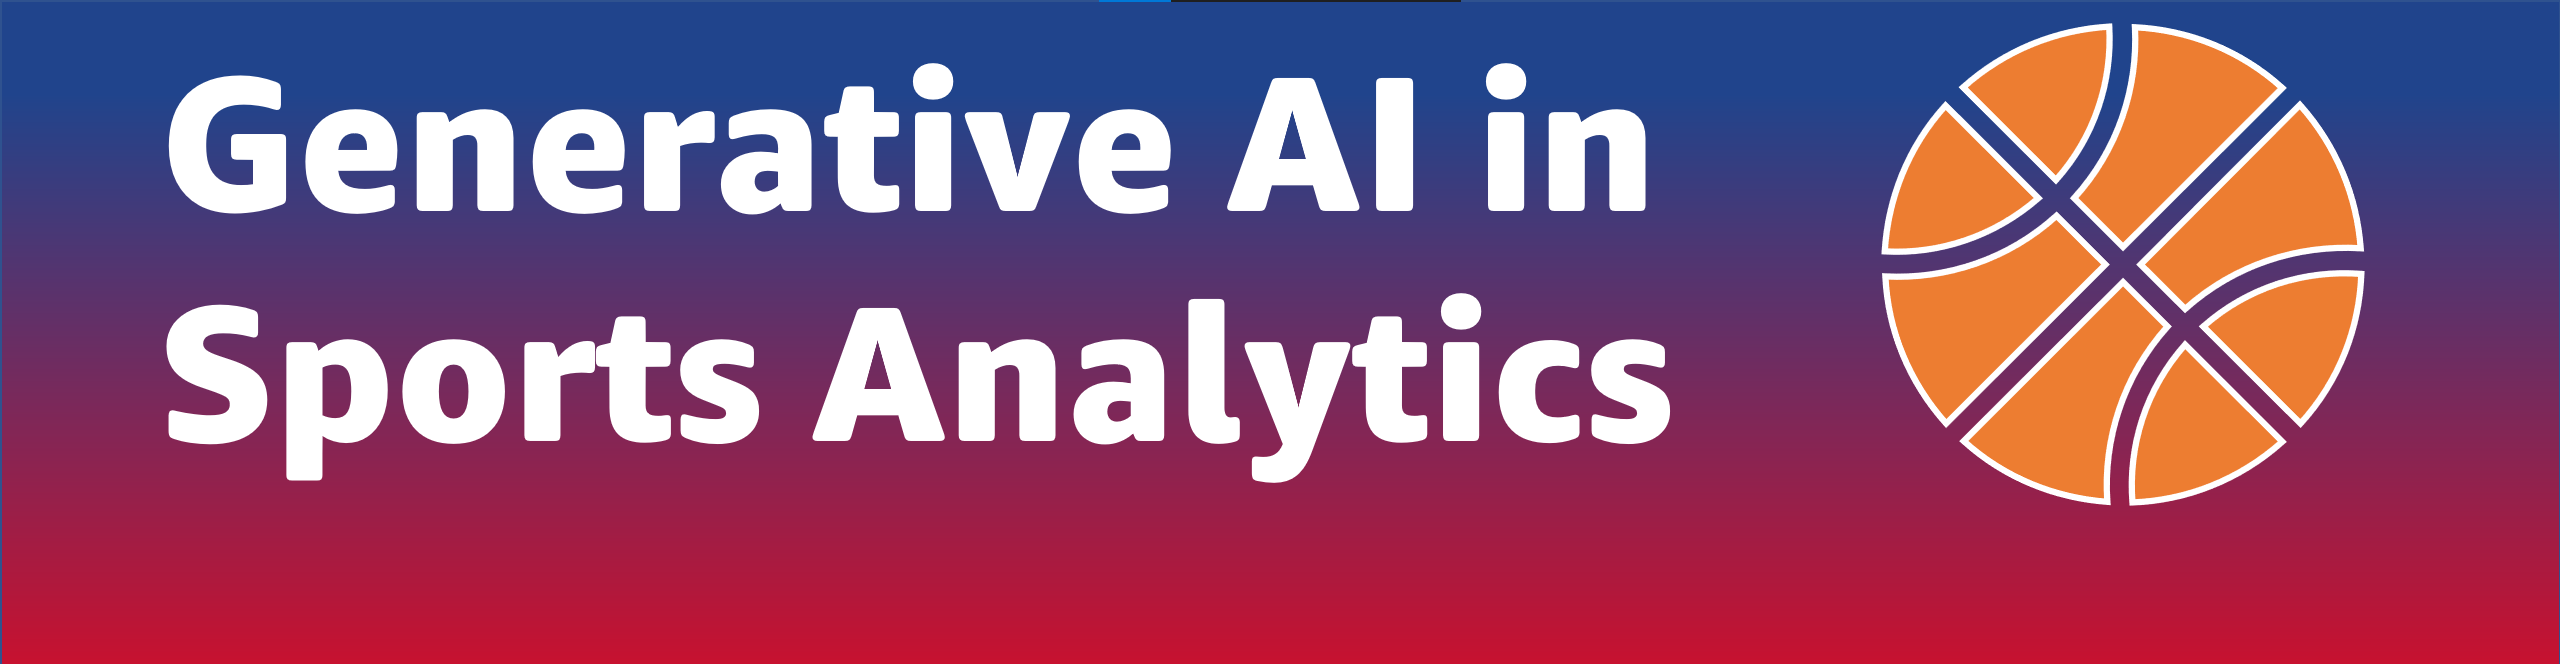

In [4]:
%pip install -U "boto3" "botocore"

  Using cached boto3-1.34.103-py3-none-any.whl.metadata (6.6 kB)
  Using cached botocore-1.34.103-py3-none-any.whl.metadata (5.7 kB)
Using cached boto3-1.34.103-py3-none-any.whl (139 kB)
Using cached botocore-1.34.103-py3-none-any.whl (12.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [288]:
import json
import boto3
from helpers import *

In [29]:
bedrock_runtime = boto3.client('bedrock-runtime')
bedrock_agent_runtime = boto3.client('bedrock-agent-runtime')

# Basic Text Generation
- Method: Invoke an Amazon Bedrock model
- LLM: Anthropic Claude 3 Haiku

In [6]:
 def invoke_anthropic_model(modelId, prompt):
        request_body = json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31", 
            "max_tokens": 512,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt
                        }
                    ]
                }
            ]
        })        
        response = bedrock_runtime.invoke_model(
            body = request_body,
            modelId = modelId,
            accept = "application/json", 
            contentType = "application/json"
        )
        response_body = json.loads(response.get("body").read())
        return response_body.get('content')[0].get('text')

In [7]:
modelId = "anthropic.claude-3-haiku-20240307-v1:0"
prompt = """What is the NBA?"""

In [8]:
print(invoke_anthropic_model(modelId, prompt))

The NBA (National Basketball Association) is the premier professional basketball league in the United States and Canada. Some key facts about the NBA:

- It is composed of 30 teams, with 29 teams in the United States and 1 team (the Toronto Raptors) in Canada.

- The NBA was founded in 1946 as the Basketball Association of America (BAA) and adopted its current name in 1949 after merging with the National Basketball League (NBL).

- It is one of the major professional sports leagues in the United States and Canada, along with the NFL (football), MLB (baseball), and NHL (ice hockey).

- The NBA season runs from October to June, and includes a regular season and postseason playoffs that culminate in the NBA Finals.

- Some of the most famous and successful NBA teams include the Los Angeles Lakers, Golden State Warriors, Boston Celtics, and Chicago Bulls.

- The NBA features some of the best basketball players in the world and has a global fanbase. It has become known for its high-scoring,

# Question answering for factual questions
- Method: Single Document Retrieval Augmented Generation (RAG)
- LLM: Anthropic Claude 3 Sonnet

In [93]:
region = 'us-west-2'
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
model_arn = f'arn:aws:bedrock:{region}::foundation-model/{model_id}'
document_uri = "s3://prompt-engineering-summit24-demo/2023–24_NBA_season_short.pdf"
session_id = None

In [94]:
def retrieveAndGenerate(input_text):
    global session_id
    input = {'text': input_text}
    config = {
        'type': 'EXTERNAL_SOURCES',
        'externalSourcesConfiguration': {
            'modelArn': model_arn,
            'sources': [
                {
                    "sourceType": "S3",
                    "s3Location": {
                        "uri": document_uri  
                    }
                }
            ]
        }
    }
    if session_id is not None:
        response = bedrock_agent_runtime.retrieve_and_generate(
            input = input,
            retrieveAndGenerateConfiguration = config,
            sessionId = session_id
        )
    else:
        response = bedrock_agent_runtime.retrieve_and_generate(
            input = input,
            retrieveAndGenerateConfiguration = config
        )
        session_id = response['sessionId']
    
    return response['output']['text']

In [108]:
prettyPrint(retrieveAndGenerate(input_text = "Who scored the most points per game?"))

<font size="3">The NBA player with the highest points per game in the 2023-24 season was Luka Dončić of the Dallas Mavericks, who averaged 33.9 points per game.</font>

In [109]:
prettyPrint(retrieveAndGenerate(input_text = "Which team has the best 3 points average?"))

<font size="3">According to the statistics for the 2023-24 NBA season, the team with the highest 3-point shooting percentage was the Oklahoma City Thunder, shooting 38.9% from beyond the arc.</font>

In [110]:
prettyPrint(retrieveAndGenerate(input_text = "Who was player of the month twice?"))

<font size="3">The player who won the NBA Player of the Month award multiple times in the 2023-24 season was Luka Dončić of the Dallas Mavericks. He won the Western Conference Player of the Month award in December 2023, February 2024, and March 2024.</font>

### Let's try something more difficult. Can the LLM calculate averages?

In [219]:
question = "What is the average number of wins for  each division?"

In [220]:
prettyPrint(retrieveAndGenerate(input_text = question))

<font size="3">Here are the average wins per division in the NBA for the 2023-24 season:

Atlantic Division: 47.6 wins
Central Division: 41.6 wins
Southeast Division: 35.0 wins
Northwest Division: 44.4 wins
Pacific Division: 48.0 wins
Southwest Division: 39.8 wins</font>

<font color='red'>Hmm, these numbers are incorrect. The LLM is hallucinating.</font>

# Summary Statistics
- Method: Text2SQL
- Model: Mistral AI - Mistral 7B Instruct
- Blog: https://aws.amazon.com/blogs/machine-learning/generating-value-from-enterprise-data-best-practices-for-text2sql-and-generative-ai/

In [231]:
def invoke_mistral_model(prompt, modelId):
    request_body = json.dumps({
        "prompt": "<s>[INST] " + prompt + " [/INST]",
        "max_tokens" : 500, 
        "temperature" : 0.5, 
        "top_p" : 0.9, 
        "top_k" : 50
    })
    response = bedrock_runtime.invoke_model(
            body = request_body,
            modelId = modelId,
            accept = "application/json", 
            contentType = "application/json"
    )
    response_body = json.loads(response.get("body").read())
    return response_body.get('outputs')[0].get('text')

In [221]:
prompt = """
You task is to generate SQL. Generate the simplest SQL statement. Output only SQL.
Given a table called "Teams" with the following columns:
Team	W	L	PCT	GB	Home	Road	GP	Division
where 'W' stands for wins and 'L' stands for losses,
Write a SQL statement to answer the question:
""" + question + """

```sql
"""

In [222]:
statement = invoke_mistral_model(prompt, "mistral.mistral-7b-instruct-v0:2")
prettyPrint(statement)

<font size="3"> SELECT Division, AVG(W) as AvgWins
FROM Teams
GROUP BY Division;</font>

### Execute the SQL Query

In [223]:
import pandas as pd
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine

def prepSQLDB(csv):
    df = pd.read_csv(csv, delimiter='\t')
    engine = create_engine("sqlite:///Teams.db")
    df.to_sql("Teams", engine, index=False)

def querySQL(statement):
    engine = create_engine("sqlite:///Teams.db")
    db = SQLDatabase(engine=engine)
    return db.run(statement)

In [ ]:
prepSQLDB('Teams.csv')

In [224]:
res = querySQL(statement)
prettyJSON(res)


```json
[('Atlantic', 43.6), ('Central', 39.4), ('Northwest', 44.4), ('Pacific', 47.8), ('Southeast', 33.0), ('Southwest', 37.8)]
```


# Data Analysis
- Method: Chain of Code (CoC)
- Model: Mistral AI - Mistral Large
- References: 

In [269]:
prompt = """
You are an expert Python programmer. Your task is to generate efficient Python code to accomplish a given task.
You must answer with code only. Do not add any text beyond the generated code.
###
Given a tab-delimited CSV file called “Teams.csv” with the following columns:
Team	W	L	PCT	GB	Home	Road	GP	Division
where 'W' stands for wins and 'L' stands for losses,
Write Python code to to answer the question:
""" + question + """
"""

In [270]:
prettyCode(invoke_mistral_model(prompt, "mistral.mistral-large-2402-v1:0"))

 ```python
import pandas as pd

# Read the CSV file
df = pd.read_csv('Teams.csv', delimiter='\t')

# Calculate the average number of wins for each division
avg_wins_per_division = df.groupby('Division')['W'].mean()

# Print the result
print(avg_wins_per_division)
```

### Execute the Python code

In [271]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('Teams.csv', delimiter='\t')

# Calculate the average number of wins for each division
avg_wins_per_division = df.groupby('Division')['W'].mean()

# Print the result
print(avg_wins_per_division)

Division
Atlantic     43.6
Central      39.4
Northwest    44.4
Pacific      47.8
Southeast    33.0
Southwest    37.8
Name: W, dtype: float64


# Data Visualization
- Method: Chain of Code (CoC) - Using PandasAI
- Model: Mistral AI - Abthriouc Claude Sonnet
- References: https://pandas-ai.com/

In [292]:
%pip install pandasai[bedrock]

  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 37.6 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 37.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 1.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 34.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.3/320.3 kB 4.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 1.6 MB/s eta 0:00:00ta 0:00:01
Using cached distro-1.9.0-py3-none-any.whl (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 777.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 899.6 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.2
    Uninstalling Ji

In [293]:
from pandasai import SmartDataframe
from pandasai.connectors import SqliteConnector
from pandasai.llm import BedrockClaude

In [294]:
connector = SqliteConnector(config={
    "database" : "Teams.db",
    "table" : "Teams",
})
llm = BedrockClaude(bedrock_runtime)
df = SmartDataframe(connector, config={"llm": llm})

In [ ]:
# # Example Questions
# df.chat("Which team had the most wins?")
# df.chat("How many teams belong to the central division?")
# df.chat("what is the highest pct")
# df.chat("what is the Hornets pct")
# df.chat("what is the Charlotte Hornets pct?")

'/root/Summit24Demo/exports/charts/temp_chart.png'

display-im6.q16: unable to open X server `' @ error/display.c/DisplayImageCommand/412.


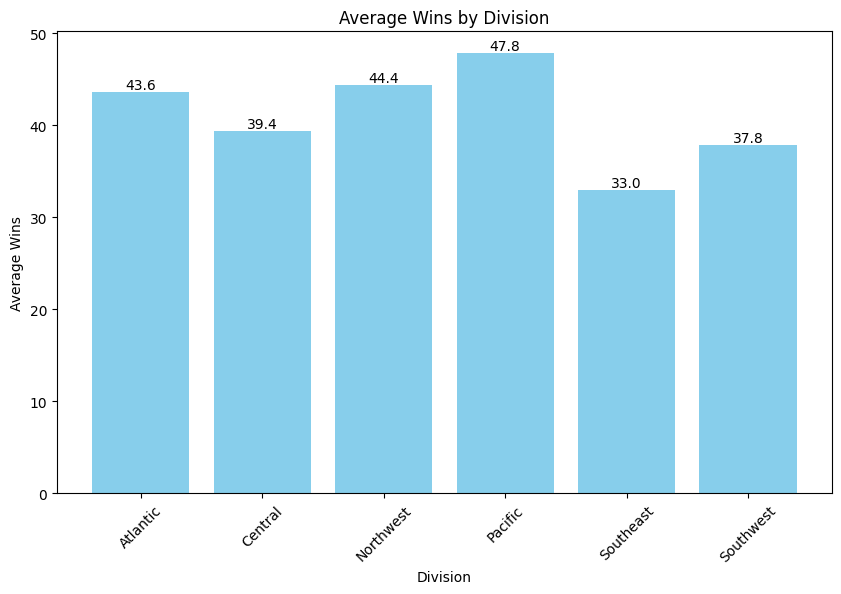

In [301]:
df.chat("Chart each division's averge wins. Include data labels")

'/root/Summit24Demo/exports/charts/temp_chart.png'

display-im6.q16: unable to open X server `' @ error/display.c/DisplayImageCommand/412.


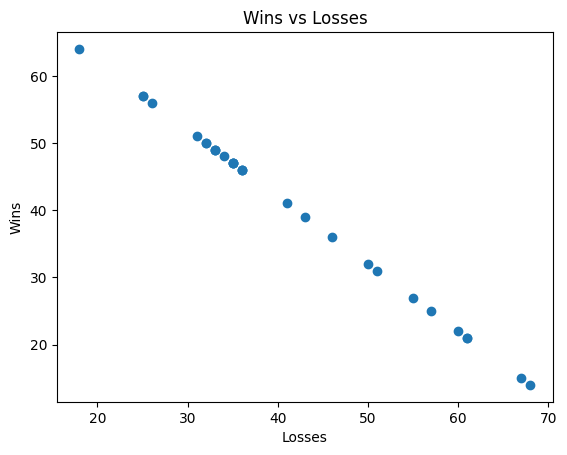

In [303]:
df.chat("Draw a scattr plot of wins versus losses. Place wins on the Y axis.")

'/root/Summit24Demo/exports/charts/temp_chart.png'

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

display-im6.q16: unable to open X server `' @ error/display.c/DisplayImageCommand/412.


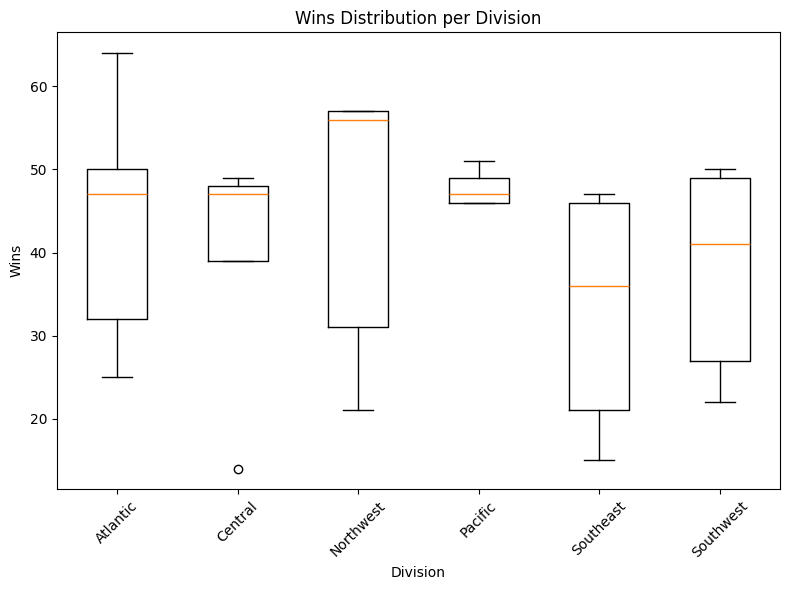

In [306]:
df.chat("Draw a boxplot to visualize wins distribution per each division")

'The Pacific division has the smallest difference between the best and worst teams.'

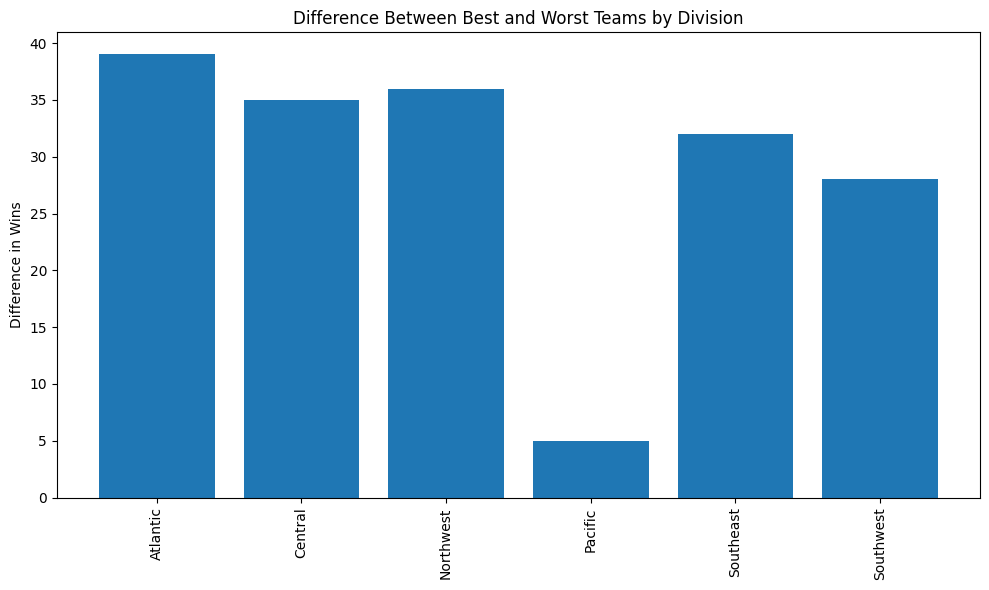

In [308]:
df.chat("Which division has the smallest difference between best and worst teams?")